# Testes de Desempenho

## K-Means

Vamos agora realizar testes de ganho de velocidade de execução, comparando o desempenho do K-Means rodando na CPU com o do K-means rodando na GPU.

Desta vez, iremos utilizar datasets bem maiores e, portanto, nada triviais — como era o caso do [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris) que foi usado anteriormente apenas como uma prova de conceito e teste de corretude.

A ideia é testar se os ganhos de desempenho ao utilizarmos uma versão paralelizada em GPU diminuem, estagnam ou aumentam junto com o aumento de instâncias ou dimensionalidade do dataset.

### Código Comum

In [2]:
import kMeans as km
import pandas as pd

import time
import os

import importlib
importlib.reload(km)

# Testing imports
print(km.kMeansCPU)
print(km.kMeansGPU)

# Valor imenso para um float, para ser usado como valor inicial na variável "slowestExecTime"
FLOAT_32_BIT_MAX = 3.4028237 * (10**38)

<function kMeansCPU at 0x78b4b5fa16c0>
<function kMeansGPU at 0x78b4b33ac7c0>


### Dataset 1 (N > 1.000, D = 7, K = 2) — Rice (Cammeo and Osmancik)

Foi utilizado aqui o Dataset **[Rice (Cammeo and Osmancik)](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik)**, que reúne dados expressando características morfológicas de grãos de arroz de duas espécies, extraídas a partir de fotos destes. Temos **7 variáveis (D = 7)** e **3.810 instâncias**.

Esse dataset também contém informações de classe, definindo qual a espécie real do grão de arroz: **Cammeo** ou **Osmancik**. Portanto, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `Rice_Cammeo_Osmancik.arff` dentro do arquivo `rice+cammeo+and+osmancik.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/545/rice+cammeo+and+osmancik.zip)).

#### Código

In [44]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 5000
PLOT_RESULTS = False
DEBUG = False

COMMENT_CHAR = '%'
ALTERNATIVE_COMMENT_CHARS = ['@']

datasetFilePath = './Rice_Cammeo_Osmancik.csv'

# Processando o aqruivo .arff file e convertendo para um arquivo .csv válido (com linhas comentadas)
if not os.path.exists(datasetFilePath):
    with \
        open('./rice+cammeo+and+osmancik/Rice_Cammeo_Osmancik.arff', 'r') as file,\
        open(datasetFilePath, 'w') as fileNew:

        for line in file:
            if line[0] in ALTERNATIVE_COMMENT_CHARS:
                fileNew.write(COMMENT_CHAR + ' ' + line[1:])
            else:
                fileNew.write(line)

columnNames = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent', 'Class']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep=',', skip_blank_lines=True, comment=COMMENT_CHAR)

dataset = dataset.drop(columns=['Class'])

print(dataset)

       Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   
0     15231  525.578979         229.749878          85.093788      0.928882  \
1     14656  494.311005         206.020065          91.730972      0.895405   
2     14634  501.122009         214.106781          87.768288      0.912118   
3     13176  458.342987         193.337387          87.448395      0.891861   
4     14688  507.166992         211.743378          89.312454      0.906691   
...     ...         ...                ...                ...           ...   
3805  11441  415.858002         170.486771          85.756592      0.864280   
3806  11625  421.390015         167.714798          89.462570      0.845850   
3807  12437  442.498993         183.572922          86.801979      0.881144   
3808   9882  392.296997         161.193985          78.210480      0.874406   
3809  11434  404.709991         161.079269          90.868195      0.825692   

      Convex_Area    Extent  
0           15617  0.

In [45]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
          Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   
0     7.083436   8.913085           9.110943           5.791756      8.992095  \
1     6.627970   7.426854           6.832784           7.035968      7.227819   
2     6.610544   7.750595           7.609142           6.293120      8.108617   
3     5.455642   5.717221           5.615196           6.233153      7.041041   
4     6.653318   8.037925           7.382246           6.582591      7.822599   
...        ...        ...                ...                ...           ...   
3805  4.081324   3.697823           3.421444           5.916006      5.587521   
3806  4.227073   3.960771           3.155323           6.610732      4.616211   
3807  4.870269   4.964124           4.677767           6.111975      6.476267   
3808  2.846418   2.577921           2.529299           4.501406      6.121153   
3809  4.075779   3.167936           2.518285  

In [46]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

NUMBER_OF_RUNS = 50

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansCPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsCPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means CPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means CPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means CPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means CPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means CPU: {fastestExecTime}')

Execution time for K-Means CPU run #1: 0.09083676338195801
Execution time for K-Means CPU run #2: 0.08794379234313965
Execution time for K-Means CPU run #3: 0.06287956237792969
Execution time for K-Means CPU run #4: 0.06355547904968262
Execution time for K-Means CPU run #5: 0.08858609199523926
Execution time for K-Means CPU run #6: 0.103759765625
Execution time for K-Means CPU run #7: 0.0551152229309082
Execution time for K-Means CPU run #8: 0.05477428436279297
Execution time for K-Means CPU run #9: 0.10375690460205078
Execution time for K-Means CPU run #10: 0.1125950813293457
Execution time for K-Means CPU run #11: 0.05472159385681152
Execution time for K-Means CPU run #12: 0.05461597442626953
Execution time for K-Means CPU run #13: 0.09595823287963867
Execution time for K-Means CPU run #14: 0.06302356719970703
Execution time for K-Means CPU run #15: 0.11109566688537598
Execution time for K-Means CPU run #16: 0.0636131763458252
Execution time for K-Means CPU run #17: 0.089097261428833

In [47]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

NUMBER_OF_RUNS = 50

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansGPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsGPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means GPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means GPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means GPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means GPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means GPU: {fastestExecTime}')

/run/media/vini/Stuff/Desktop/Facul/TCC2/ufu-tcc2/.venv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 6 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/run/media/vini/Stuff/Desktop/Facul/TCC2/ufu-tcc2/.venv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Execution time for K-Means GPU run #1: 0.02894902229309082
Execution time for K-Means GPU run #2: 0.019762277603149414
Execution time for K-Means GPU run #3: 0.027919292449951172
Execution time for K-Means GPU run #4: 0.034171342849731445
Execution time for K-Means GPU run #5: 0.020323753356933594
Execution time for K-Means GPU run #6: 0.01817154884338379
Execution time for K-Means GPU run #7: 0.020333290100097656
Execution time for K-Means GPU run #8: 0.027330875396728516
Execution time for K-Means GPU run #9: 0.020391464233398438
Execution time for K-Means GPU run #10: 0.04353666305541992
Execution time for K-Means GPU run #11: 0.019257068634033203
Execution time for K-Means GPU run #12: 0.019730329513549805
Execution time for K-Means GPU run #13: 0.017033100128173828
Execution time for K-Means GPU run #14: 0.01765918731689453
Execution time for K-Means GPU run #15: 0.02324843406677246
Execution time for K-Means GPU run #16: 0.01739811897277832
Execution time for K-Means GPU run #17:

### Dataset 2 (N > 10.000, D = 8, K = 2) — HTRU2

Foi utilizado aqui o Dataset **[HTRU2 (High Time Resolution Universe 2)](https://archive.ics.uci.edu/dataset/372/htru2)**, que reúne dados a respeito de emissões de sinais de rádio de banda larga obtidos através de leituras feitas com telescópios de rádio. É um dos resultados da busca por pulsares, estrelas de neutrôn que possuem uma rotação rápida e que emitem sinais de rádio banda larga detectáveis do nosso planeta. Temos **8 variáveis (D = 8)** e **17.898 instâncias**.

Esse dataset também contém informações de classe, definindo se a leitura é **positiva** ou **negativa**, a respeito do sinal candidato de fato originar ou não de um pulsar. Portanto, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `HTRU_2.csv` dentro do arquivo `HTRU_2.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/372/htru2.zip)).

#### Código

In [48]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 5000
PLOT_RESULTS = False
DEBUG = False

datasetFilePath = './htru2/HTRU_2.csv'

columnNames = ['mean_IP', 'std_dev_IP', 'exc_kurt_IP', 'skew_IP', 'mean_DM_SNR', 'std_dev_DM_SNR', 'exc_kurt_DM_SNR', 'skew_DM_SNR', 'is_positive']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep=',')

dataset = dataset.drop(columns=['is_positive'])

print(dataset)

          mean_IP  std_dev_IP  exc_kurt_IP   skew_IP  mean_DM_SNR   
0      140.562500   55.683782    -0.234571 -0.699648     3.199833  \
1      102.507812   58.882430     0.465318 -0.515088     1.677258   
2      103.015625   39.341649     0.323328  1.051164     3.121237   
3      136.750000   57.178449    -0.068415 -0.636238     3.642977   
4       88.726562   40.672225     0.600866  1.123492     1.178930   
...           ...         ...          ...       ...          ...   
17893  136.429688   59.847421    -0.187846 -0.738123     1.296823   
17894  122.554688   49.485605     0.127978  0.323061    16.409699   
17895  119.335938   59.935939     0.159363 -0.743025    21.430602   
17896  114.507812   53.902400     0.201161 -0.024789     1.946488   
17897   57.062500   85.797340     1.406391  0.089520   188.306020   

       std_dev_DM_SNR  exc_kurt_DM_SNR  skew_DM_SNR  
0           19.110426         7.975532    74.242225  
1           14.860146        10.576487   127.393580  
2        

In [49]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
        mean_IP  std_dev_IP  exc_kurt_IP   skew_IP  mean_DM_SNR   
0      7.492075    4.759187     2.485386  1.140645     1.120440  \
1      5.658651    5.148176     3.118736  1.164410     1.059040   
2      5.683117    2.771815     2.990246  1.366092     1.117270   
3      7.308394    4.940954     2.635746  1.148810     1.138310   
4      4.994689    2.933627     3.241398  1.375405     1.038944   
...         ...         ...          ...       ...          ...   
17893  7.292961    5.265529     2.527670  1.135690     1.043698   
17894  6.624482    4.005425     2.813468  1.272336     1.653146   
17895  6.469407    5.276293     2.841869  1.135059     1.855621   
17896  6.236795    4.542553     2.879693  1.227544     1.069897   
17897  3.469156    8.421307     3.970340  1.242264     8.585104   

       std_dev_DM_SNR  exc_kurt_DM_SNR  skew_DM_SNR  
0            2.023125         3.654872     1.575009  
1            1.652719   

In [50]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

NUMBER_OF_RUNS = 50

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansCPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsCPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means CPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means CPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means CPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means CPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means CPU: {fastestExecTime}')

Execution time for K-Means CPU run #1: 0.3568580150604248
Execution time for K-Means CPU run #2: 0.341508150100708
Execution time for K-Means CPU run #3: 0.3079385757446289
Execution time for K-Means CPU run #4: 0.3914024829864502
Execution time for K-Means CPU run #5: 0.17243194580078125
Execution time for K-Means CPU run #6: 0.37250638008117676
Execution time for K-Means CPU run #7: 0.3691294193267822
Execution time for K-Means CPU run #8: 0.36617445945739746
Execution time for K-Means CPU run #9: 0.3073537349700928
Execution time for K-Means CPU run #10: 0.4008347988128662
Execution time for K-Means CPU run #11: 0.4331042766571045
Execution time for K-Means CPU run #12: 0.34552955627441406
Execution time for K-Means CPU run #13: 0.28484511375427246
Execution time for K-Means CPU run #14: 0.28101038932800293
Execution time for K-Means CPU run #15: 0.5807054042816162
Execution time for K-Means CPU run #16: 0.4000563621520996
Execution time for K-Means CPU run #17: 0.3398551940917969
E

In [52]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

NUMBER_OF_RUNS = 50

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansGPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsGPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means GPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means GPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means GPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means GPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means GPU: {fastestExecTime}')

Execution time for K-Means GPU run #1: 0.08824300765991211
Execution time for K-Means GPU run #2: 0.10289621353149414
Execution time for K-Means GPU run #3: 0.11167287826538086
Execution time for K-Means GPU run #4: 0.07661294937133789
Execution time for K-Means GPU run #5: 0.10092306137084961
Execution time for K-Means GPU run #6: 0.0882878303527832
Execution time for K-Means GPU run #7: 0.05552482604980469
Execution time for K-Means GPU run #8: 0.06119704246520996
Execution time for K-Means GPU run #9: 0.0928199291229248
Execution time for K-Means GPU run #10: 0.07871627807617188
Execution time for K-Means GPU run #11: 0.07607626914978027
Execution time for K-Means GPU run #12: 0.11084628105163574
Execution time for K-Means GPU run #13: 0.09688472747802734
Execution time for K-Means GPU run #14: 0.0768132209777832
Execution time for K-Means GPU run #15: 0.10115528106689453
Execution time for K-Means GPU run #16: 0.0999293327331543
Execution time for K-Means GPU run #17: 0.07020568847

### Dataset 3 (N > 100.000, D = 50, K = 2) — MiniBooNE

Foi utilizado aqui o Dataset **[MiniBooNE Particle Identification](https://archive.ics.uci.edu/dataset/199/miniboone+particle+identification)**, que reúne dados a respeito de partículas detectadas no experimento *MiniBooNE* (*Mini Booster Neutrino Experiment*), conduzido no laboratório americano *Fermilab*. Cada detecção de partícula é descrita por **50 variáveis reais (D = 50)** e há **129.596 instâncias no total**.

As primeiras 36.488 instâncias são detecções de neutrinos do elétron (sinal) e as 93.108 restantes são de neutrinos do múon (ruído de fundo). Assim, as informações de classe desse dataset estão implícitas, expressa pela ordem das instâncias no arquivo. Como temos duas classes, haverão **2 grupos de dados (K = 2)**.

Esse conjunto de dados está presente no arquivo `MiniBooNE_PID.txt` dentro do arquivo `miniboone+particle+identification.zip` do dataset (também disponível em download direto [neste link](https://archive.ics.uci.edu/static/public/199/miniboone+particle+identification.zip)).

Foi necessário, neste dataset, realizar um **pré-processamento** para **remoção de outliers**. Originalmente, há 130.064 instâncias no total (36.499 sinal e 93.565 ruído). Porém, existem 468 instâncias (11 sinal e 457 ruído) que são extremos outliers, possuindo o valor -999.0 em todas as 50 variáveis — provavelmente advindos de algum erro de detecção. A presença destes outliers causava a criação de um cluster contendo apenas estes outliers, diminuindo muito o tempo de execução do algoritmo de maneira artificial. Estes outliers tiveram que ser removidos. Note que poderíamos ter solucionado este problema com outra abordagem: aumentar K para 3, criando um cluster novo para conter apenas os outliers. Isso, no entanto, seria mais custoso computacionalmente do que a remoção das instâncias.

#### Código

In [39]:
# Novas variáveis globais
K = 2
MAX_ITERATIONS = 5000
PLOT_RESULTS = True
DEBUG = True

COMMENT_CHAR = '#'

# As primeiras 36.499 instâncias são consideradas um sinal, e o resto como ruído
N_OF_SIGNAL_LINES = 36499

datasetFilePath = './MiniBooNE_PID.csv'

# Processando o aqruivo .txt file e convertendo para um arquivo .csv válido (com a primeira linha comentada, removendo o leading whitespace, e trocando o separador de "  " ou " " para ",")
if not os.path.exists(datasetFilePath):
    with \
        open('./MiniBooNE_PID.txt', 'r') as file,\
        open(datasetFilePath, 'w') as fileNew:

        print('Processing MiniBooNE_PID.txt...\n ')

        # Removendo outliers com -999.0 de valor nas 50 variáveis. Há 468 destas instâncias
        outlierString = '''-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03,-0.999000E+03'''

        index = 1
        signalInstRemoved = 0
        noiseInstRemoved = 0
        for line in file:
            if index != 1:
                lineToWrite = line.strip(' ').replace('  ', ' ').replace(' ', ',')
                if outlierString not in lineToWrite:
                    fileNew.write(lineToWrite)
                else:
                    if index - 1 <= N_OF_SIGNAL_LINES:
                        # print(f'Instance (signal) #{index - 1} removed...')
                        signalInstRemoved += 1
                    else:
                        # print(f'Instance (noise) #{index - 1} removed...')
                        noiseInstRemoved += 1
            # else:
            #     fileNew.write(COMMENT_CHAR + ' ' + line.strip(' ').replace('  ', ' '))
            index += 1

        print(f'Signal outlier instances removed = {signalInstRemoved}')
        print(f'Noise outlier instances removed = {noiseInstRemoved}\n ')

        print(f'Processed dataset saved in {datasetFilePath} with success!\n ')
else:
    print(f'Processed dataset found in {datasetFilePath}. No need for processing!\n ')

columnNames = [f'id_var_{i}' for i in range(1, 50 + 1) ]

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFile, names=columnNames, sep=',', skip_blank_lines=True)

# # Removendo 468x todas as instâncias com os valores mínimos de cada variável
# # (Um total de 472 instâncias acabam sendo removidas do dataset)
# for i in range(468):
#     outlierIdxs = []

#     for idx in dataset.idxmin():
#         if idx not in outlierIdxs:
#             print(f'Instance #{idx} removed!')
#             outlierIdxs.append(idx)

#     # for idx in dataset.idxmax():
#     #     if idx not in outlierIdxs: outlierIdxs.append(idx)
#     # # print(outlierIdxs)

#     if len(outlierIdxs) > 2:
#         print(f'Index #{i + 1}: len(outlierIdxs)={len(outlierIdxs)}')

#     dataset = dataset.drop(index=outlierIdxs)

print(dataset)

Processing MiniBooNE_PID.txt...
 
Signal outlier instances removed = 11
Noise outlier instances removed = 457
 
Processed dataset saved in ./MiniBooNE_PID.csv with success!
 
        id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0        2.59413  0.468803   20.6916  0.322648  0.009682  0.374393  0.803479  \
1        3.86388  0.645781   18.1375  0.233529  0.030733  0.361239  1.069740   
2        3.38584  1.197140   36.0807  0.200866  0.017341  0.260841  1.108950   
3        4.28524  0.510155  674.2010  0.281923  0.009174  0.000000  0.998822   
4        5.93662  0.832993   59.8796  0.232853  0.025066  0.233556  1.370040   
...          ...       ...       ...       ...       ...       ...       ...   
129591   4.80718  1.451020  174.6920  0.343481  0.002174  0.000000  0.747401   
129592   5.00527  1.501860  129.9270  0.273477  0.006098  0.109769  1.325370   
129593   3.10842  2.178140   56.3651  0.211850  0.000000  0.167382  1.318900   
129594   5.44560  1.84570

In [40]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
        id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0       2.368749  1.421131  1.039201  4.103207  5.452597  5.787233  2.158663  \
1       3.038712  1.603309  1.034359  2.834322  6.017928  5.619037  2.542627   
2       2.786482  2.170867  1.068374  2.369263  5.658285  4.335283  2.599170   
3       3.261035  1.463698  2.278040  3.523361  5.438966  1.000000  2.440359   
4       4.132359  1.796021  1.113489  2.824697  5.865742  3.986399  2.975677   
...          ...       ...       ...       ...       ...       ...       ...   
129591  3.536428  2.432206  1.331135  4.399829  5.250969  1.000000  2.077796   
129592  3.640947  2.484539  1.246275  3.403106  5.356339  2.403578  2.911261   
129593  2.640106  3.180688  1.106826  2.525655  5.192588  3.140255  2.901930   
129594  3.873280  2.838481  1.196108  3.601499  5.620371  2.374501  1.980500   
129595  3.401059  2.319715  1.151798  3.547153  5.192588 

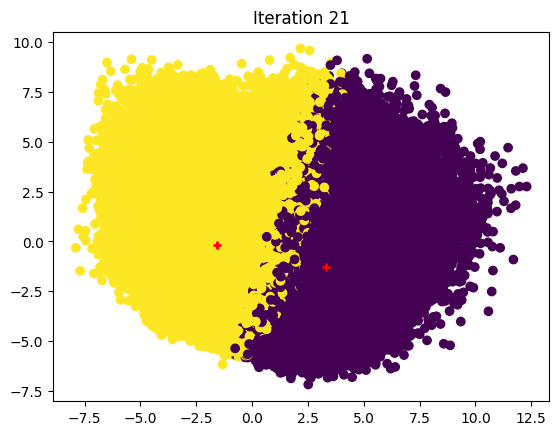

Centroids:
   id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0  3.941966  2.880463  1.202962  3.762023  5.343593  2.081553  2.156218  \
1  3.332798  2.116448  1.223470  3.309564  5.474804  2.974190  2.447405   

   id_var_8  id_var_9  id_var_10  ...  id_var_41  id_var_42  id_var_43   
0  7.943603  3.184247   3.180829  ...   4.266468   6.735528   1.493978  \
1  8.633994  2.894491   3.634281  ...   4.246563   7.087931   1.450952   

   id_var_44  id_var_45  id_var_46  id_var_47  id_var_48  id_var_49  id_var_50  
0   1.689460   1.211942   4.190370   9.355279   5.422920   4.970803   4.035055  
1   1.497901   1.073078   3.170231   9.483622   5.031461   4.736726   4.352783  

[2 rows x 50 columns]

Distances:
               0         1
0       9.796062  5.872512
1       9.300252  6.110352
2       6.069195  4.122433
3       7.042289  4.113800
4       5.769501  4.741198
...          ...       ...
129591  7.481505  5.535303
129592  4.792719  3.240106
129593  8.439772  5

In [41]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

NUMBER_OF_RUNS = 1

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansCPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsCPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means CPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means CPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means CPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means CPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means CPU: {fastestExecTime}')

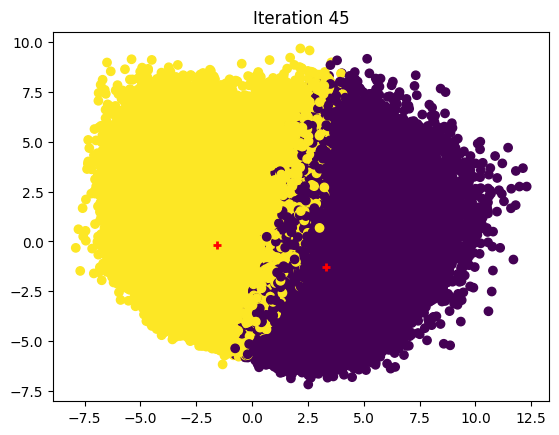

Centroids:
   id_var_1  id_var_2  id_var_3  id_var_4  id_var_5  id_var_6  id_var_7   
0  3.941701  2.881708  1.202862  3.762584  5.343451  2.081097  2.156165  \
1  3.333608  2.116850  1.223490  3.309872  5.474703  2.973151  2.447041   

   id_var_8  id_var_9  id_var_10  ...  id_var_41  id_var_42  id_var_43   
0  7.943323  3.183952   3.180621  ...   4.265428   6.735685   1.494165  \
1  8.633225  2.894964   3.633779  ...   4.247065   7.087398   1.450922   

   id_var_44  id_var_45  id_var_46  id_var_47  id_var_48  id_var_49  id_var_50  
0   1.688673   1.211267   4.189188   9.355619   5.423175   4.971225   4.035334  
1   1.498451   1.073518   3.171761   9.483300   5.031828   4.736829   4.352227  

[2 rows x 50 columns]

Distances:
[[9.79926441 5.87557408]
 [9.30585846 6.11064312]
 [6.07431327 4.12147526]
 ...
 [8.44249249 5.89634393]
 [3.8208284  6.27348859]
 [5.7198517  3.37399755]]

Closest centroid index:
[1 1 1 ... 1 0 1]


Execution time for K-Means GPU run #1: 44.376423358917236
 
A

In [42]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

NUMBER_OF_RUNS = 1

totalExecTime = 0.0
slowestExecTime = -1.0
fastestExecTime = FLOAT_32_BIT_MAX

for rep in range(1, NUMBER_OF_RUNS + 1):
    startTime = time.time()
    km.kMeansGPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
    # print(f'Results:\n \n{resultsGPU}\n ')
    elapsedTime = time.time() - startTime
    print(f'Execution time for K-Means GPU run #{rep}: {elapsedTime}')
    if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
    if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
    totalExecTime += elapsedTime
    # print(f'Average execution time for K-Means GPU until now: {totalExecTime / rep}')

print(f' \nAverage execution time for K-Means GPU: {totalExecTime / NUMBER_OF_RUNS}')
print(f'Slowest execution time for K-Means GPU: {slowestExecTime}')
print(f'Fastest execution time for K-Means GPU: {fastestExecTime}')

### Dataset 4 (N > 1.000.000, D = 8) — WESAD

Foi utilizado aqui um sub-conjunto dos dados do Dataset **[WESAD (Wearable Stress and Affect Detection)](https://archive.ics.uci.edu/dataset/465/wesad+wearable+stress+and+affect+detection)**, que reúne dados, fisiológicos e de movimento, de diversos sensores presentes em aparelhos *wearables* usados por 15 pacientes diferentes em testes laboratoriais. Um aparelho foi usado no peitoral e outro no pulso dos pacientes.

Esse dataset também contém informações de classe, definindo momentos dos testes como pertencendo à três classificações de emoção do paciente: **referência**, **estresse** ou **diversão**. Portanto, haverão **3 grupos de dados (K = 3)**.

O sub-conjunto de dados utilizado foi: dados obtidos apenas através do **aparelho usado no peito** do paciente, e apenas do **paciente #4**. Utilizando este sub-conjunto, temos **8 variáveis (D = 8)** e **4.588.552 instâncias**, cada uma sendo uma leitura ao longo do tempo do teste laboratorial (leituras realizadas na frequência de 700hz).

Esse sub-conjunto de dados está presente no arquivo `S4/S4_respiban.txt` dentro do arquivo `WESAD.zip` do dataset (também disponível em download direto [neste link](https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download)).

#### Código

In [5]:
# Novas variáveis globais
K = 3
MAX_ITERATIONS = 5000
PLOT_RESULTS = False
DEBUG = False

datasetFilePath = './WESAD/S4/S4_respiban.txt'
columnNames = ['index', 'DI', 'ECG', 'EDA', 'EMG', 'TEMP', 'spatialX', 'spatialY', 'spatialZ', 'RESPIRATION', '_ignore_']

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames, sep='\t', index_col=0, skip_blank_lines=True, comment='#')

dataset = dataset.drop(columns=['DI', '_ignore_'])

print(dataset)

           ECG   EDA    EMG   TEMP  spatialX  spatialY  spatialZ  RESPIRATION
index                                                                        
0        34487  2844  32819  27563     37495     32437     31921        33292
1        34274  2869  32481  27560     37485     32433     31935        33295
2        33960  2774  32431  27557     37471     32445     31927        33293
3        33737  2767  32561  27555     37485     32433     31925        33308
4        33602  2768  32696  27562     37487     32429     31909        33300
...        ...   ...    ...    ...       ...       ...       ...          ...
4588548  33272  6470  32721  26727     37539     32597     32256        31863
4588549  33389  6467  32360  26726     37543     32583     32253        31865
4588550  33497  6456  32357  26719     37530     32598     32243        31857
4588551  33499  6450  32175  26733     37539     32585     32263        31855
4588552  33425  6445  32340  26753     37525     32595     32237

In [18]:
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
              ECG       EDA       EMG      TEMP  spatialX  spatialY  spatialZ   
index                                                                           
0        5.735295  1.508909  4.175522  8.925593  5.800000  5.203079  4.600799  \
1        5.706038  1.527215  3.927640  8.903516  5.789437  5.196481  4.607789   
2        5.662907  1.457652  3.890971  8.881439  5.774648  5.216276  4.603795   
3        5.632276  1.452526  3.986310  8.866721  5.789437  5.196481  4.602796   
4        5.613733  1.453258  4.085316  8.918234  5.791549  5.189883  4.594808   
...           ...       ...       ...       ...       ...       ...       ...   
4588548  5.568405  4.164022  4.103651  2.773508  5.846479  5.467009  4.768057   
4588549  5.584475  4.161826  3.838902  2.766149  5.850704  5.443915  4.766559   
4588550  5.599310  4.153771  3.836701  2.714636  5.836972  5.468658  4.761567   
4588551  5.599585  4.149378  3.703227  2.81766

In [6]:

# * ####################################
# * Rodando o K-Means CPU
# * ####################################

# NUMBER_OF_RUNS = 100

# totalExecTime = 0.0
# slowestExecTime = -1.0
# fastestExecTime = FLOAT_32_BIT_MAX

# for rep in range(1, NUMBER_OF_RUNS + 1):
#     startTime = time.time()
#     km.kMeansCPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
#     # print(f'Results:\n \n{resultsCPU}\n ')
#     elapsedTime = time.time() - startTime
#     print(f'Execution time for K-Means CPU run #{rep}: {elapsedTime}')
#     if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
#     if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
#     totalExecTime += elapsedTime
#     # print(f'Average execution time for K-Means CPU until now: {totalExecTime / rep}')

# print(f' \nAverage execution time for K-Means CPU: {totalExecTime / NUMBER_OF_RUNS}')
# print(f'Slowest execution time for K-Means CPU: {slowestExecTime}')
# print(f'Fastest execution time for K-Means CPU: {fastestExecTime}')

In [20]:

# * ####################################
# * Rodando o K-Means GPU
# * ####################################

# NUMBER_OF_RUNS = 100

# totalExecTime = 0.0
# slowestExecTime = -1.0
# fastestExecTime = FLOAT_32_BIT_MAX

# for rep in range(1, NUMBER_OF_RUNS + 1):
#     startTime = time.time()
#     km.kMeansGPU(datasetTreated, k=K, maxIter=MAX_ITERATIONS, printIter=False, plotResults=PLOT_RESULTS, debug=DEBUG)
#     # print(f'Results:\n \n{resultsGPU}\n ')
#     elapsedTime = time.time() - startTime
#     print(f'Execution time for K-Means GPU run #{rep}: {elapsedTime}')
#     if elapsedTime < fastestExecTime: fastestExecTime = elapsedTime
#     if elapsedTime > slowestExecTime: slowestExecTime = elapsedTime
#     totalExecTime += elapsedTime
#     # print(f'Average execution time for K-Means GPU until now: {totalExecTime / rep}')

# print(f' \nAverage execution time for K-Means GPU: {totalExecTime / NUMBER_OF_RUNS}')
# print(f'Slowest execution time for K-Means GPU: {slowestExecTime}')
# print(f'Fastest execution time for K-Means GPU: {fastestExecTime}')

#### Resultados

> Resultados completos disponíveis no arquivo `code/examples-and-tests/speedupTestsRawResults.txt`

| |Tempo médio (50 execuções)|Speedup Médio|
|-|-|-|
|K-Means CPU|~129,81s|-|
|K-Means GPU|~27,87s|~4,65x|

### Dataset 5 (N > 10.000.000)

In [21]:
# TBA